http://iot-ee.com/en/2017/08/07/analysing-iot-data-introduction-time-series-forecasting-python/ ARTICLE

https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data DATA

https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average WIKIPEDIA ARIMA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
path = "/Users/robincole/Documents/Data/Kaggle/"
df_all = pd.read_csv(path+'GlobalLandTemperaturesByCountry.csv', delimiter=',')
df_all.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [3]:
df_france = df_all.drop('AverageTemperatureUncertainty', axis=1)

In [4]:
df_france = df_france[df_france.Country == 'France']

In [5]:
df_france = df_france.drop('Country', axis=1)

In [6]:
df_france.index = pd.to_datetime(df_france.dt)

In [7]:
df_france = df_france.drop('dt', axis=1)

In [8]:
df_france = df_france.ix['1990-01-01':]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [9]:
df_france.isnull().sum()

AverageTemperature    1
dtype: int64

In [10]:
df_france = df_france.sort_index()

In [11]:
df_france.AverageTemperature.fillna(method='pad', inplace=True)

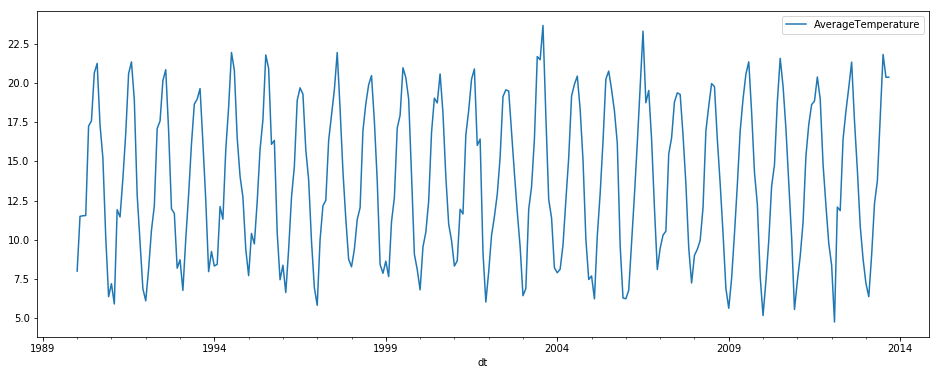

In [12]:
df_france.plot(figsize=(16, 6));

## Checking data stationarity 
Stationarity is an assumption underlying many statistical procedures used in time series analysis and particularly in ARIMA modelling. Time series  data are said to be stationary if their statistical properties such as mean and variance remain constant over time and its autocorrelation does not depend on time. Trend and seasonality usually affect the stationarity of a time series…but not always.

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

1. constant mean
2. constant variance
3. an autocovariance that does not depend on time.

To check for data stationarity, we can first simply plot the data and analyse visually whether there is any trend or seasonality. Usually it is hard to see it visually: in that case, we can, for instance, plot the rolling mean and see if it varies over time. Statsmodels library offers a statistical tool called the Augmented Dickey-Fuller Test which helps finding out stationary properties in a collection of data. The function below plots the rolling mean and then performs the Augmented Dickey-Fuller test.

In [13]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    # Perform Augmented Dickey-Fuller test:
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """


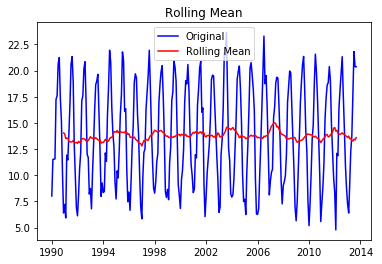

Results of Augmented Dickey-Fuller test:
Test Statistic                  -4.447606
p-value                          0.000244
#Lags Used                      14.000000
Number of Observations Used    270.000000
Critical Value (1%)             -3.454804
Critical Value (5%)             -2.872305
Critical Value (10%)            -2.572506
dtype: float64


In [14]:
test_stationarity(df_france.AverageTemperature)

We can see that the trend is almost invariant over the time. The average temperature is around 13° in the beginning and goes up around 14° starting from 1996.

Moreover, the Augmented Dickey-Fuller test is showing that the data is stationary: the p-value is small (<0.005) and the Test Statistic is lower than the Critical Value (1%), so it can be concluded with 99% confidence that the data is stationary.

If the data is not stationary, we need to make it so. One known way to do that is with differencing. This example shows how to differenciate time series data in order to make it stationary using Python.

## Modelling and forecasting
ARIMA stands for Auto-Regressive Integrated Moving Averages. So, ARIMA is the combinaison of 3 models, Auto regressive, Integrated and Moving averages models that depend respectively on the parameters (p,d,q): 
1. Auto regressive - p represents the number of Auto-Regressive (AR) terms. A variable is a linear function of past lags of itself. 
2. Integrated - d represents the order of differencing. Differencing is a way of transforming a non-stationary series to a stationary one. 
3. Moving averages - q represents the number of Moving Averages (MA) terms. In Moving-Average models, a variable is a linear function of the residuals from previous periods. q represents the number of lags of residuals to consider.

If your data is already stationary, you do not need the Integrated (I) part of ARIMA. You just need the ARMA model which is a linear combination of AR(p) and MA(q) terms.

## How to find the best values for p and q parameters?

There are many ways to find the right values for p and q parameters. One way is to directly observe the plots of ACF (Autocorrelation function) and PACF (Partial Autocorrelation function). ACF measures the correlation between the time series data yt and a lagged version of itself yt–h. PACF measures the correlation between yt and yt–h after removing linear dependence on y1, y2, …, yt–h+1. This means that the intermediate correlations are eliminated and we keep only the residual correlation between yt and yt–h. ACF and PACF are tools to analyse the dependencies in a time series. So let’s plot ACF and PACF:

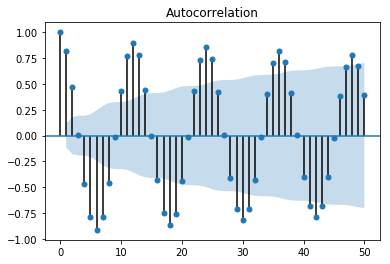

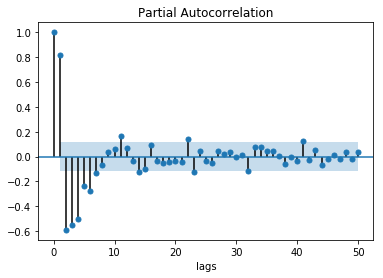

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_acf(df_france.AverageTemperature, lags=50)
plot_pacf(df_france.AverageTemperature, lags=50)
plt.xlabel('lags')
plt.show()

So, back to our plots, both ACF and PACF graphs above, show exponential decrease and some sinusoidal components. We can guess then that we have both AR and MA terms with orders higher than 1. PACF drops considerably at lag p=2 (it starts at zero at the graph but it represents the first lag) and ACF drops considerably at lag q=3, this gives us an  estimation of the ARMA order = (2,3). The purple shadow on the two graphs represents the 95% confidence interval.

Usually, using ACF and PACF only isn’t enough to find the best values for p and q parameters that avoid overfitting the model. The best way to tune these parameters is to grid-search them. To evaluate and compare different ARMA models with different parameters p and q, we will use the AIC (Akaike Information Criterion) value, which is returned with ARIMA models in statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. We will write this code to do it.

In [16]:
from statsmodels.tsa.arima_model import ARMA
import itertools
p = q = range(0, 4)
pq = itertools.product(p, q)
for param in pq:
    try:
        mod = ARMA(df_france.AverageTemperature,order=param)
        results = mod.fit()
        print('ARMA{} - AIC:{}'.format(param, results.aic))
    except:
        continue

ARMA(0, 0) - AIC:1706.562013730846
ARMA(0, 1) - AIC:1468.228420962078
ARMA(1, 0) - AIC:1391.7464366384593
ARMA(1, 1) - AIC:1333.6499198811416


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


ARMA(1, 2) - AIC:1457.59344084946
ARMA(1, 3) - AIC:1364.1006599131329
ARMA(2, 0) - AIC:1261.5626065873503


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARMA(2, 2) - AIC:964.0905568602358


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARMA(2, 3) - AIC:958.9303663155307
ARMA(3, 0) - AIC:1161.0768328607626
ARMA(3, 2) - AIC:1009.7682486816564


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:587: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:587: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same fit. Thus, we are interested in finding the model that yields the lowest AIC value. The lowest returned AIC value above, is for (p,q)=(3,2). So we wil be using ARMA(3,2) model in the following to fit the data, we will also measure the MSE between real data and fitted data.

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated

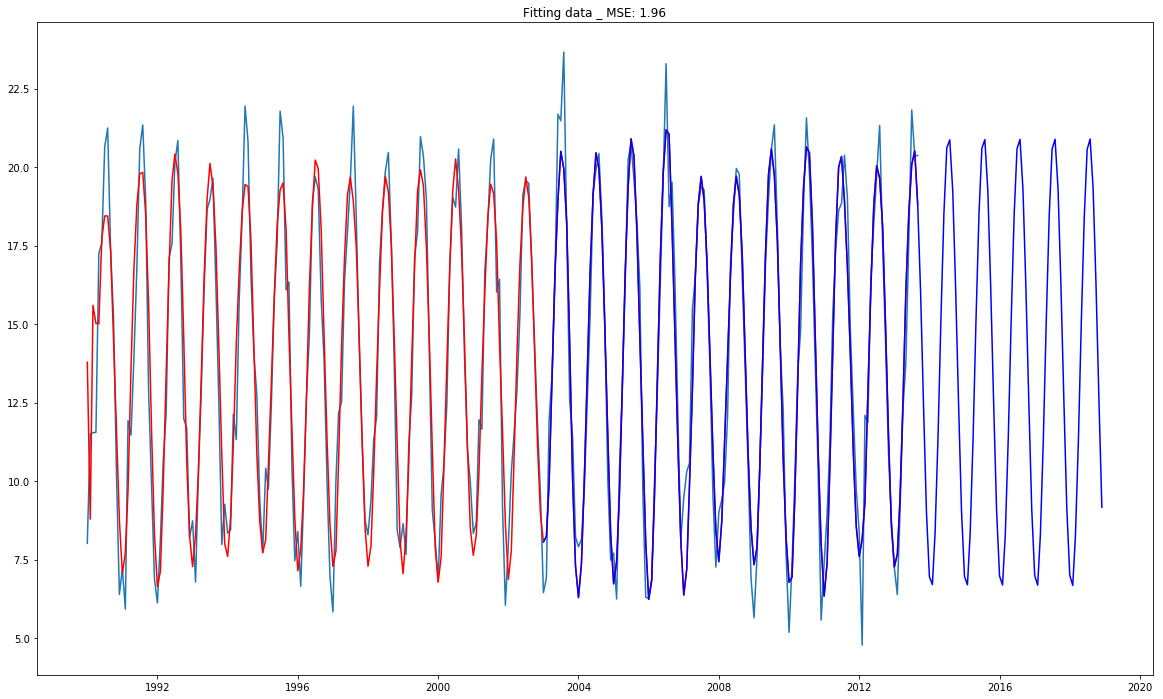

In [17]:
model = ARMA(df_france.AverageTemperature, order=(3,2))  
results_MA = model.fit()  
predictions = results_MA.predict('01/01/2003', '12/01/2018')
plt.figure(figsize=(20,12))
plt.plot(df_france.AverageTemperature)
plt.plot(results_MA.fittedvalues, color='red')
plt.plot(predictions, color='blue')
plt.title('Fitting data _ MSE: %.2f'% (((results_MA.fittedvalues-df_france.AverageTemperature)**2).mean()))
plt.show()

Now, that we defined a model for our time series data and estimated its MSE, we can use it to produce forecasts: